# Next-item Prediction using DynamicRec
> Improve accuracy of in-session recommenders using dynamic convolutional layers to train next-item recommender model

- toc: true
- badges: true
- comments: true
- categories: [Convolution, Session, Sequential, PyTorch, LastFM]
- image:

### Introduction

| |  |
| :-: | -:|
| Vision | Improve accuracy of in-session recommenders |
| Mission | Use dynamic convolutional layers to train next-item recommender model  |
| Scope | Model training, Offline evaluation, Single pre-processed dataset |
| Task | Next-item Prediction |
| Data | LastFM, YooChoose, NowPlaying, Diginetica |
| Tool | PyTorch, Colab, Python |
| Technique | DynamicRec: A Dynamic Convolutional Network for Next Item Recommendation |
| Process | 1) Load pre-processed dataset, 2) Prepare Utils and Model layers, 3) Train the model, 4) Evaluate |
| Takeaway | Convolution-based NN models are lightweight and estimate the sequence very well. |
| Credit | [Mehrab Tanjim](https://github.com/Mehrab-Tanjim) |
| Link | [link1](https://github.com/Mehrab-Tanjim/DynamicRec), [link2](http://cseweb.ucsd.edu/~gary/pubs/mehrab-cikm-2020.pdf) |

### Libraries

In [1]:
import os
import csv
import math
import pickle
import random
import argparse
import numpy as np
import pandas as pd
from random import shuffle
from torch.utils import data
from collections import defaultdict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

### Datasets

There are 4 datasets, already preprocessed:

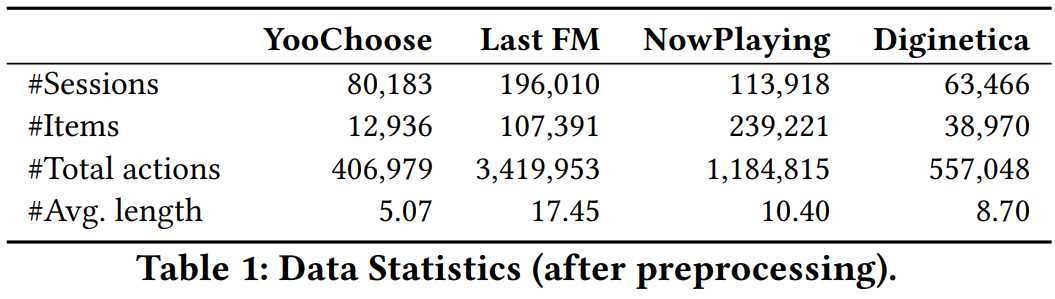

In [2]:
#hide-output
!wget https://github.com/recohut/reco-data/raw/master/yoochoose/v3/yoochoose.csv
!wget https://github.com/recohut/reco-data/raw/master/lastfm/v3/last_fm.csv
!wget https://github.com/recohut/reco-data/raw/master/nowplaying/v3/nowplaying.csv
!wget https://github.com/recohut/reco-data/raw/master/diginetica/v3/diginetica.csv

--2021-07-16 17:38:25--  https://github.com/recohut/reco-data/raw/master/yoochoose/v3/yoochoose.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/recohut/reco-data/master/yoochoose/v3/yoochoose.csv [following]
--2021-07-16 17:38:26--  https://raw.githubusercontent.com/recohut/reco-data/master/yoochoose/v3/yoochoose.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2878952 (2.7M) [text/plain]
Saving to: ‘yoochoose.csv’

yoochoose.csv       100%[===================>]   2.75M  --.-KB/s    in 0.02s   

2021-07-16 17:38:26 (172 MB/s) - ‘yoochoose.csv’ saved [2878952/2878952]

--2021-07-16 17:38:2

### PyTorch Dataset

In [3]:
class Dataset(data.Dataset):

    'Characterizes a dataset for PyTorch'
    def __init__(self, data, args, itemnum, train):
            'Initialization'
            self.data = data
            self.args = args
            self.itemnum = itemnum
            self.train = train

    def __len__(self):
            'Denotes the total number of samples'            
            return len(self.data)

    def __train__(self, index):
            
            session = np.asarray(self.data[index], dtype=np.int64)
    
            if len(session) > self.args.maxlen:
                session = session[-self.args.maxlen:]
            else:
                session = np.pad(session, (self.args.maxlen-len(session), 0), 'constant', constant_values=0)

            curr_seq = session[:-1]
            curr_pos = session[1:]

            return curr_seq, curr_pos
    
    def __test__(self, index):

            session = self.data[index]

            seq = np.zeros([self.args.maxlen], dtype=np.int64)
            idx = self.args.maxlen - 1

            for i in reversed(session[:-1]): #everything except the last one
                seq[idx] = i
                idx -= 1
                if idx == -1: break

            return seq, session[-1]-1 #index of the item in the list of all items

    def __getitem__(self, index):
            'Generates one sample of data'
            # Select sample

            if self.train:
                return self.__train__(index)
            else:
                return self.__test__(index)

### Train/Val/Test Split

In [4]:
def data_partition(fname, percentage=[0.1, 0.2]):
    itemnum = 0

    sessions = defaultdict(list)
    session_train = []
    session_valid = []
    session_test = []
    # assume user/item index starting from 1
    session_id = 0
    f = open(fname, 'r')
    total_length = 0
    max_length = 0
    for line in f:

        items = [int(l) for l in line.rstrip().split(',')]

        if len(items) < 5: continue
        total_length += len(items)

        if max_length< len(items):
            max_length = len(items)
        
        itemnum = max(max(items), itemnum)
        sessions[session_id].append(items)
        session_id += 1

    print("Avg length:", total_length/session_id)
    print("Maximum length:", max_length)

    valid_perc = percentage[0]
    test_perc = percentage[1]

    total_sessions = session_id
    
    shuffle_indices = np.random.permutation(range(total_sessions)) #
    
    train_index = int(total_sessions*(1 - valid_perc - test_perc))
    valid_index = int(total_sessions*(1 - test_perc))

    if (train_index == valid_index): valid_index += 1 #break the tie
    
    train_indices = shuffle_indices[:train_index]
    valid_indices = shuffle_indices[train_index:valid_index]
    test_indices = shuffle_indices[valid_index:]

    for i in train_indices:
        session_train.extend(sessions[i])
    for i in valid_indices:
        session_valid.extend(sessions[i])
    for i in test_indices:
        session_test.extend(sessions[i])
    
    return [np.asarray(session_train), np.asarray(session_valid), np.asarray(session_test), itemnum]

### Next Item Format

In [5]:
def saveAsNextItNetFormat(fname, maxlen):
        
    sessions = []

    # assume user/item index starting from 1
    f = open(fname, 'r')

    for line in f:

        items = [int(l) for l in line.rstrip().split(',')]

        if len(items) < 5: continue
        
        seq = np.zeros([maxlen], dtype=np.int32)
        
        idx = maxlen - 1

        for i in reversed(items):
            seq[idx] = i
            idx -= 1
            if idx == -1: break        
        
        sessions.append(seq)
        
    print("number of session:", len(sessions))

    with open(fname+'_nextitnet_format.csv',"w",newline='') as my_csv:
        csvWriter = csv.writer(my_csv, delimiter=',')
        csvWriter.writerows(sessions)

### GRU Format

In [6]:
def saveAsGRUFormat(fname, user_train, user_valid, user_test):
    
    session_id = 0
    train = []
    for session in user_train:
        for item in session:
            train.append([session_id, item, 0])
        session_id += 1

    valid = []
    for session in user_valid:
        for item in session:
            valid.append([session_id, item, 0])
        session_id += 1

    test = []
    for session in user_test:
        for item in session:
            test.append([session_id, item, 0])
        session_id += 1

    train_data = pd.DataFrame(train, columns= ['SessionId', 'ItemId', 'Time'])
    valid_data = pd.DataFrame(valid, columns= ['SessionId', 'ItemId', 'Time'])
    test_data = pd.DataFrame(test, columns= ['SessionId', 'ItemId', 'Time'])

    train_data.to_csv(fname+'_grurec_train_data.csv',  sep=' ', index=None)
    valid_data.to_csv(fname+'_grurec_valid_data.csv',  sep=' ', index=None)
    test_data.to_csv(fname+'_grurec_test_data.csv',  sep=' ', index=None)

### PyTorch Evaluation Function

In [7]:
def evaluate(model, test_sessions, itemnum, args, num_workers=4):
    #set the environment
    model.eval()
    
    MRR = 0.0
    NDCG = 0.0
    HT = 0.0

    MRR_plus_10 = 0.0
    NDCG_plus_10 = 0.0
    HT_plus_10 = 0.0

    valid_sessions = 0.0


    all_items = np.array(range(1, itemnum+1))
    all_items_tensor = torch.LongTensor(all_items).to(args.computing_device, non_blocking=True)

    dataset = Dataset(test_sessions, args, itemnum, False)

    sampler = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size, num_workers=num_workers, pin_memory=True)

    with torch.no_grad():
            
        for step, (seq, grouth_truth) in tqdm(enumerate(sampler), total=len(sampler)): 

            seq = torch.LongTensor(seq).to(args.computing_device, non_blocking=True)
            
            _, rank_20 = model.forward(seq, test_item = all_items_tensor)

            rank_20 = rank_20.cpu().detach().numpy()
            grouth_truth = grouth_truth.view(-1, 1).numpy()
            

            try:
                ranks = np.where(rank_20 == grouth_truth)

                try:
                    ranks = ranks[1]
                except:
                    ranks = ranks[0]

                for rank in ranks:

                    if rank < args.top_k:
                        
                        MRR += 1.0/(rank + 1)
                        NDCG += 1 / np.log2(rank + 2)
                        HT += 1

                    if rank < args.top_k + 10:

                        MRR_plus_10 += 1.0/(rank + 1)
                        NDCG_plus_10 += 1 / np.log2(rank + 2)
                        HT_plus_10 += 1
                
            except:
                continue #where rank returns none
                    
        valid_sessions = len(dataset)

    return MRR / valid_sessions, NDCG / valid_sessions, HT / valid_sessions, MRR_plus_10 / valid_sessions, NDCG_plus_10 / valid_sessions, HT_plus_10 / valid_sessions

### Embeddings

Know more - https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

In [8]:
def Embedding(num_embeddings, embedding_dim, padding_idx):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, mean=0, std=embedding_dim ** -0.5)
    nn.init.constant_(m.weight[padding_idx], 0)
    return m

In [9]:
# initialize embeddings of length 3 for 5 objects
_x = Embedding(num_embeddings=5, embedding_dim=3, padding_idx=0)

# and show these embeddings
input = torch.LongTensor([[0,1,2,3,4]])

_x(input)

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.5082, -1.2240,  0.4601],
         [ 0.3713,  0.4553,  0.2050],
         [ 1.4143, -0.0746, -1.0692],
         [ 0.4730,  0.0228,  0.2250]]], grad_fn=<EmbeddingBackward>)

### Layer Normalization

Know more - https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

In [10]:
def LayerNorm(normalized_shape, eps=1e-5, elementwise_affine=True):
    if torch.cuda.is_available():
        try:
            from apex.normalization import FusedLayerNorm
            return FusedLayerNorm(normalized_shape, eps, elementwise_affine)
        except ImportError:
            pass
    return torch.nn.LayerNorm(normalized_shape, eps, elementwise_affine)

In [11]:
input = torch.randn(2, 2, 3)
input

tensor([[[ 0.4966, -0.0399,  0.2787],
         [-0.0880, -0.5890, -2.0534]],

        [[-0.8865,  0.3536,  1.2280],
         [ 0.5236, -1.8695,  1.0614]]])

In [12]:
_x = LayerNorm(normalized_shape=[2, 3], eps=1e-5, elementwise_affine=True)

_x(input)

tensor([[[ 0.9870,  0.3483,  0.7276],
         [ 0.2910, -0.3054, -2.0486]],

        [[-0.8665,  0.2588,  1.0522],
         [ 0.4131, -1.7585,  0.9010]]], grad_fn=<NativeLayerNormBackward>)

### Linear Layer

In [13]:
def Linear(in_features, out_features, bias=True):
    m = nn.Linear(in_features, out_features, bias)
    nn.init.xavier_uniform_(m.weight)
    if bias:
        nn.init.constant_(m.bias, 0.)
    return m

In [14]:
input = torch.randn(6, 5)
input

tensor([[ 1.0741,  0.3984, -2.2572,  0.4323, -1.1037],
        [-0.9142,  1.2374, -0.7267,  2.1540, -0.5734],
        [ 0.9580, -0.9858,  2.4790, -1.5683,  1.4305],
        [-0.4465, -0.8673, -0.1499, -0.0307, -1.2711],
        [-0.6461,  1.3322,  0.9776, -1.4097, -0.7225],
        [-1.0695,  2.4115,  1.3938, -0.3121, -1.1786]])

In [15]:
_x = Linear(in_features=5, out_features=2, bias=True)

_x(input)

tensor([[-0.3837, -0.6764],
        [-1.7173, -0.6000],
        [ 0.7086,  2.1441],
        [-0.1996, -0.9117],
        [ 0.4004,  0.3742],
        [-1.0578,  0.8000]], grad_fn=<AddmmBackward>)

### Tensor Unfolding

In [16]:
def unfold1d(x, kernel_size, padding_l, pad_value=0):
    '''unfold T x B x C to T x B x C x K'''
    if kernel_size > 1:
        T, B, C = x.size()
        x = F.pad(x, (0, 0, 0, 0, padding_l, kernel_size - 1 - padding_l), value=pad_value)
        x = x.as_strided((T, B, C, kernel_size), (B*C, C, 1, B*C))
    else:
        x = x.unsqueeze(3)
    return x

In [17]:
input = torch.randn(3, 2, 2)
input

tensor([[[-0.2890,  0.6461],
         [ 0.8582,  0.6208]],

        [[ 0.2950, -0.4533],
         [-0.4343, -2.5247]],

        [[-0.6954, -0.8405],
         [-0.1281, -0.3957]]])

In [18]:
unfold1d(input, kernel_size=2, padding_l=0, pad_value=0).shape

torch.Size([3, 2, 2, 2])

### Dynamic Convolution

Know more - https://fairseq.readthedocs.io/en/latest/modules.html?highlight=DynamicConv1dTBC#fairseq.modules.DynamicConv1dTBC

Other references:-
- https://arxiv.org/abs/1912.03458
- https://youtu.be/FNkY7I2R_zM
- [Medium blog post](https://medium.com/visionwizard/dynamic-convolution-an-exciting-innovation-over-convolution-kernels-from-microsoft-research-f3cb433cd780)

In [19]:
class DynamicConv1dTBC(nn.Module):

    '''
    # Copyright (c) Facebook, Inc. and its affiliates.
    #
    # This source code is licensed under the MIT license found in the
    # LICENSE file in the root directory of this source tree: https://github.com/pytorch/fairseq
    # 
    # Dynamic lightweight convolution taking T x B x C inputs
    Args:
        input_size: # of channels of the input
        kernel_size: convolution channels
        padding_l: padding to the left when using "same" padding
        num_heads: number of heads used. The weight is of shape (num_heads, 1, kernel_size)
        weight_dropout: the drop rate of the DropConnect to drop the weight
        weight_softmax: normalize the weight with softmax before the convolution
        renorm_padding: re-normalize the filters to ignore the padded part (only the non-padding parts sum up to 1)
        bias: use bias
        conv_bias: bias of the convolution
        query_size: specified when feeding a different input as the query
        in_proj: project the input and generate the filter together
    Shape:
        Input: TxBxC, i.e. (timesteps, batch_size, input_size)
        Output: TxBxC, i.e. (timesteps, batch_size, input_size)
    Attributes:
        weight: the learnable weights of the module of shape
            `(num_heads, 1, kernel_size)`
        bias:   the learnable bias of the module of shape `(input_size)`
    '''
    def __init__(self, input_size, kernel_size=1, padding_l=None, num_heads=1, unfold=False,
                 weight_dropout=0., weight_softmax=False,
                 renorm_padding=False, bias=False, conv_bias=False,
                 query_size=None):
        super().__init__()
        self.input_size = input_size
        self.query_size = input_size if query_size is None else query_size
        self.kernel_size = kernel_size
        self.padding_l = padding_l
        self.num_heads = num_heads
        self.weight_dropout = weight_dropout
        self.weight_softmax = weight_softmax
        self.renorm_padding = renorm_padding
        self.unfold = unfold
        self.weight_linear = Linear(self.query_size, num_heads * kernel_size * 1, bias=bias) 

        if conv_bias:
            self.conv_bias = nn.Parameter(torch.Tensor(input_size))
        else:
            self.conv_bias = None
        self.reset_parameters()

    @property
    def in_proj(self):
        return self.weight_linear.out_features == self.input_size + self.num_heads * self.kernel_size

    def reset_parameters(self):
        self.weight_linear.reset_parameters()
        if self.conv_bias is not None:
            nn.init.constant_(self.conv_bias, 0.)

    def forward(self, x, incremental_state=None, query=None):
        '''Assuming the input, x, of the shape T x B x C and producing an output in the shape T x B x C
        args:
            x: Input of shape T x B x C, i.e. (timesteps, batch_size, input_size)
            incremental_state: A dict to keep the state
            unfold: unfold the input or not. If not, we use the matrix trick instead
            query: use the specified query to predict the conv filters
        '''
    
        query = x

        output = self._forward_unfolded(x, incremental_state, query)
        

        if self.conv_bias is not None:
            output = output + self.conv_bias.view(1, 1, -1)

        return output

    def _forward_unfolded(self, x, incremental_state, query):
        '''The conventional implementation of convolutions.
        Unfolding the input by having a window shifting to the right.'''
        T, B, C = x.size()
        K, H = self.kernel_size, self.num_heads
        R = C // H   
        
        assert R * H == C == self.input_size

        
        weight = self.weight_linear(query).view(T*B*H, -1) 
        
        weight = F.dropout(weight, self.weight_dropout, training=self.training, inplace=False)


        padding_l = self.padding_l
        if K > T and padding_l == K-1:
            weight = weight.narrow(1, K-T, T)
            K, padding_l = T, T-1
        # unfold the input: T x B x C --> T' x B x C x K
        x_unfold = unfold1d(x, K, padding_l, 0)
        x_unfold = x_unfold.view(T*B*H, R, K)

        if self.weight_softmax:
            weight = F.softmax(weight, dim=1)
            
        weight = weight.narrow(1, 0, K)
      
        output = torch.bmm(x_unfold, weight.unsqueeze(2)) # T*B*H x R x 1
        output = output.view(T, B, C)
        return output

In [20]:
# Input: TxBxC, i.e. (timesteps, batch_size, input_size)
input = torch.randn(3, 2, 3)
input

tensor([[[-0.4056, -0.6844, -0.9592],
         [-0.8878, -1.1988,  0.1743]],

        [[-0.0566, -1.1467,  1.4102],
         [ 0.4096,  1.1338,  0.0059]],

        [[-1.6808,  0.5988, -0.2367],
         [-0.4198,  0.4105,  0.7927]]])

In [21]:
_x = DynamicConv1dTBC(input_size=3)

In [22]:
# Output: TxBxC, i.e. (timesteps, batch_size, input_size)
_x.forward(input)

tensor([[[ 6.1792e-02,  1.0425e-01,  1.4611e-01],
         [-2.9698e-01, -4.0100e-01,  5.8310e-02]],

        [[-2.1421e-02, -4.3430e-01,  5.3408e-01],
         [-4.2870e-02, -1.1866e-01, -6.2266e-04]],

        [[-9.9575e-01,  3.5476e-01, -1.4026e-01],
         [-1.6986e-01,  1.6608e-01,  3.2072e-01]]], grad_fn=<ViewBackward>)

### ConvRec Layer

In [23]:
class ConvRecLayer(nn.Module):
   

    def __init__(self, args,  kernel_size=0):
        super().__init__()
        self.embed_dim = args.embed_dim
        
        self.conv = DynamicConv1dTBC(args.embed_dim, kernel_size, padding_l=kernel_size-1,
                                         weight_softmax=args.weight_softmax,
                                         num_heads=args.heads,
                                         unfold = None, 
                                         weight_dropout=args.weight_dropout)
        
        self.dropout = args.dropout
        self.layer_norm = LayerNorm(self.embed_dim)

        self.fc1 = Linear(self.embed_dim, args.ffn_embed_dim)
        self.fc2 = Linear(args.ffn_embed_dim, self.embed_dim)


    def forward(self, x, conv_mask=None,
                conv_padding_mask=None):
        
        T, B, C = x.size()
        
        x = self.conv(x)
        x = self.layer_norm(x)  
        attn = None
        residual = x
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x += residual
        return x, attn

### ConvRec Model

**Abstract**

*Recently convolutional networks have shown significant promise for modeling sequential user interactions for recommendations. Critically, such networks rely on fixed convolutional kernels to capture sequential behavior. In this paper, we argue that all the dynamics of the item-to-item transition in session-based settings may not be observable at training time. Hence we propose DynamicRec, which uses dynamic convolutions to compute the convolutional kernels on the fly based on the current input. We show through experiments that this approach significantly outperforms existing convolutional models on real datasets in session-based settings.*

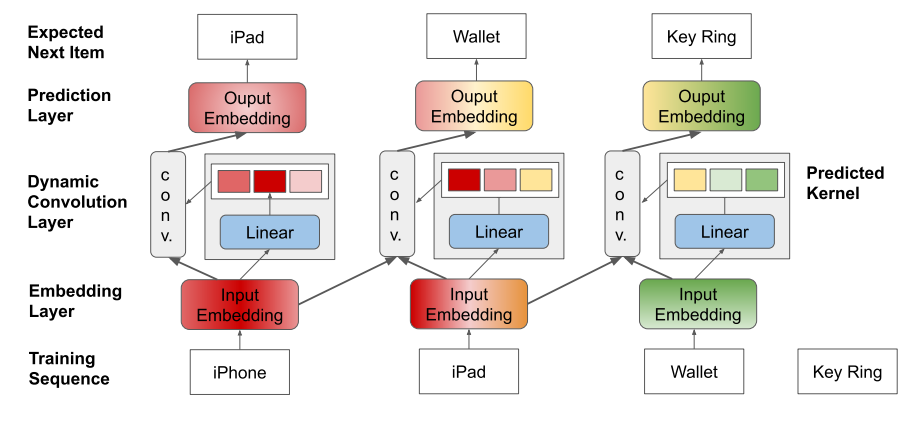

In [24]:
class ConvRec(nn.Module):
    
    def __init__(self, args, itemnum):
        super(ConvRec, self).__init__()
        
        add_args(args)

        self.args = args
        self.dropout = args.dropout
        self.maxlen = args.maxlen
        self.itemnum = itemnum

        self.item_embedding = Embedding(itemnum + 1, args.embed_dim, 0)
        self.embed_scale = math.sqrt(args.embed_dim)  
        self.position_encoding = Embedding(args.maxlen, args.embed_dim, 0)
        
        self.layers = nn.ModuleList([])
        self.layers.extend([
            ConvRecLayer(args, kernel_size=args.decoder_kernel_size_list[i])
            for i in range(args.layers)
        ])
        
        self.layer_norm = LayerNorm(args.embed_dim)

    def forward(self, seq, pos=None, neg=None, test_item = None):
        
 
        x =  self.item_embedding(seq)
        

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        attn = None

        inner_states = [x]

        # decoder layers
        for layer in self.layers:
            x = self.layer_norm(x)
            x, attn = layer(x)
            inner_states.append(x)

        # if self.normalize:
        x = self.layer_norm(x)

        # T x B x C -> B x T x C
        x = x.transpose(0, 1)
        
        seq_emb = x.contiguous().view(-1, x.size(-1)) # reshaping it to [arg.batch_size x args.maxlen * args.hidden_units]
        pos_logits = None 
        neg_logits = None 
        rank_20 = None 
        istarget = None
        loss = None

        if pos is not None:
            pos = torch.reshape(pos, (-1,))

            nnz = torch.ne(pos, 0).nonzero().squeeze(-1)
            neg = torch.randint(1,self.itemnum+1, (self.args.num_neg_samples, nnz.size(0)), device=self.args.computing_device)

            pos_emb = self.item_embedding(pos[nnz])
            neg_emb = self.item_embedding(neg)
            seq_emb = seq_emb[nnz]

            #sequential context
            pos_logits = torch.sum(pos_emb * seq_emb, -1)
            neg_logits = torch.sum(neg_emb * seq_emb, -1)
            negative_scores = torch.sum((1 - torch.sigmoid(neg_logits) + 1e-24).log(), axis = 0)

            loss = torch.sum(-(torch.sigmoid(pos_logits) + 1e-24).log() - negative_scores)/nnz.size(0)

                
        if test_item is not None:        

            test_item_emb = self.item_embedding(test_item)
            seq_emb = seq_emb.view(seq.size(0), seq.size(1), -1)
            seq_emb = seq_emb[:, -1, :]
            seq_emb = seq_emb.contiguous().view(-1, seq_emb.size(-1))
            test_logits = torch.mm(seq_emb, test_item_emb.t()) #check

            test_logits_indices = torch.argsort(-test_logits)
            rank_20 = test_logits_indices[:, :20]

        return loss, rank_20

In [25]:
def add_args(args):

    if len(args.decoder_kernel_size_list) == 1: # For safety in case kernel size list does not match with # of convolution layers
        args.decoder_kernel_size_list = args.decoder_kernel_size_list * args.layers

    args.weight_softmax = True

    print("Model arguments", args)

### Argument Parsing

In [26]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='last_fm.csv')
parser.add_argument('--top_k', default=10, type=int)

parser.add_argument('--train_dir', default='default')
parser.add_argument('--batch_size', default=128, type=int)
parser.add_argument('--lr', default=0.001, type=float)

parser.add_argument('--maxlen', default=30, type=int)

parser.add_argument('--embed_dim', default=200, type=int) 
parser.add_argument('--ffn_embed_dim', default=200, type=int)
parser.add_argument('--dropout', default=0.2, type=float) 
parser.add_argument('--weight_dropout', default=0.2, type=float)


parser.add_argument('--layers', default=2, type=int) 
parser.add_argument('--heads', default=1, type=int) 

parser.add_argument('--decoder_kernel_size_list', default = [5, 5]) #depends on the number of layer

parser.add_argument('--num_epochs', default=30, type=int)
parser.add_argument('--num_neg_samples', default = 400, type=int) #Note: 100 is sufficient
parser.add_argument('--eval_epoch', default = 5, type=int)

_StoreAction(option_strings=['--eval_epoch'], dest='eval_epoch', nargs=None, const=None, default=5, type=<class 'int'>, choices=None, help=None, metavar=None)

In [27]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else:  # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

parser.add_argument('--computing_device', default=computing_device)

# # Get the arguments
try:
    #if running from command line
    args = parser.parse_args(args={})
except:
    #if running in IDEs
    args = parser.parse_known_args(args={})[0] 

CUDA is supported


In [28]:
result_path = 'results/'+args.dataset + '_' + args.train_dir

if not os.path.isdir(result_path):
    os.makedirs(result_path)
with open(os.path.join(result_path, 'args.txt'), 'w') as f:
    f.write('\n'.join([str(k) + ',' + str(v) for k, v in sorted(vars(args).items(), key=lambda x: x[0])]))
f.close()

### Loading the Data

In [29]:
!mkdir -p ./data && mv ./*.csv ./data

In [30]:
if os.path.exists("data/"+args.dataset + '.pkl'):
    pickle_in = open("data/"+args.dataset+".pkl","rb")
    dataset = pickle.load(pickle_in)
else:
    dataset = data_partition("data/"+args.dataset)
    pickle_out = open("data/"+args.dataset+".pkl","wb")
    pickle.dump(dataset, pickle_out)
    pickle_out.close()

Avg length: 17.447849599510228
Maximum length: 49


In [31]:
[train, valid, test, itemnum] = dataset

print("Number of sessions:",len(train)+len(valid)+len(test))
print("Number of items:", itemnum)

action = 0
for i in train:
    action += np.count_nonzero(i)

for i in valid:
    action += np.count_nonzero(i)


for i in test:
    action += np.count_nonzero(i)

print("Number of actions:", action)

print("Average length of sessions:", action/(len(train)+len(valid)+len(test)))


num_batch = len(train) // args.batch_size
print("The batch size is:", num_batch)

Number of sessions: 196010
Number of items: 107391
Number of actions: 3419953
Average length of sessions: 17.447849599510228
The batch size is: 1071


### Loading the Pre-trained Model if exist

In [32]:
f = open(os.path.join(result_path, 'log.txt'), 'w')

conv_model = ConvRec(args, itemnum)
conv_model = conv_model.to(args.computing_device, non_blocking=True)

# Note: testing a pretrained model
if os.path.exists(result_path+"pretrained_model.pth"):
    conv_model.load_state_dict(torch.load(result_path+"pretrained_model.pth"))       
    t_test = evaluate(conv_model, test, itemnum, args, num_workers=4)
    model_performance = "Model performance on test: "+str(t_test)
    print(model_performance)


optimizer = optim.Adam(conv_model.parameters(), lr = args.lr, betas=(0.9, 0.98), weight_decay = 0.0)

f.write(str(args)+'\n')
f.flush()

Model arguments Namespace(batch_size=128, computing_device=device(type='cuda'), dataset='last_fm.csv', decoder_kernel_size_list=[5, 5], dropout=0.2, embed_dim=200, eval_epoch=5, ffn_embed_dim=200, heads=1, layers=2, lr=0.001, maxlen=30, num_epochs=30, num_neg_samples=400, top_k=10, train_dir='default', weight_dropout=0.2, weight_softmax=True)


### Training the Model

In [33]:
best_val_loss = 1e6
train_losses = []
val_losses = []

best_ndcg = 0
best_hit = 0
model_performance = None

stop_count = 0
total_epochs = 1    

dataset = Dataset(train, args, itemnum, train=True)

  
sampler = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size, num_workers=4, pin_memory=True)

for epoch in range(1, args.num_epochs + 1):  
    conv_model.train()

    epoch_losses = []

    
    for step, (seq, pos) in tqdm(enumerate(sampler), total=len(sampler)):  
            
        optimizer.zero_grad()


        seq = torch.LongTensor(seq).to(args.computing_device, non_blocking=True)
        pos = torch.LongTensor(pos).to(args.computing_device, non_blocking=True)

        loss, _  = conv_model.forward(seq, pos=pos)

        epoch_losses.append(loss.item())

        # Compute gradients
        loss.backward()

        # Update the parameters
        optimizer.step()
        
    
    if total_epochs % args.eval_epoch == 0:

        t_valid = evaluate(conv_model, valid, itemnum, args, num_workers=4)
        
        print ('\nnum of steps:%d, valid (MRR@%d: %.4f, NDCG@%d: %.4f, HR@%d: %.4f), valid (MRR@%d: %.4f, NDCG@%d: %.4f, HR@%d: %.4f)' % (total_epochs, args.top_k, t_valid[0], args.top_k, t_valid[1], args.top_k, t_valid[2],
        args.top_k+10, t_valid[3], args.top_k+10, t_valid[4], args.top_k+10, t_valid[5]))

        f.write(str(t_valid) + '\n')
        f.flush()

        
        if t_valid[0]>best_ndcg:
            best_ndcg = t_valid[0]
            torch.save(conv_model.state_dict(), result_path+"pretrained_model.pth")
            stop_count = 1
        else:
            stop_count += 1

        if stop_count == 3: #model did not improve 3 consequetive times
            break
            
    total_epochs += 1

    train_loss = np.mean(epoch_losses)
    print(str(epoch) + "epoch loss", train_loss)

100%|██████████| 1072/1072 [01:05<00:00, 16.34it/s]

1epoch loss 7.3527167292673195



100%|██████████| 1072/1072 [01:05<00:00, 16.44it/s]

2epoch loss 2.8364792477283904



100%|██████████| 1072/1072 [01:05<00:00, 16.40it/s]

3epoch loss 2.5269355415853103



100%|██████████| 1072/1072 [01:05<00:00, 16.39it/s]

4epoch loss 2.3478677922220372



100%|██████████| 154/154 [00:03<00:00, 47.91it/s]



num of steps:5, valid (MRR@10: 0.1069, NDCG@10: 0.1455, HR@10: 0.2710), valid (MRR@20: 0.1131, NDCG@20: 0.1683, HR@20: 0.3618)
5epoch loss 2.227214479513133


100%|██████████| 1072/1072 [01:05<00:00, 16.39it/s]

6epoch loss 2.1392917673089613



100%|██████████| 1072/1072 [01:05<00:00, 16.37it/s]

7epoch loss 2.0716234180909483



100%|██████████| 1072/1072 [01:05<00:00, 16.39it/s]

8epoch loss 2.0193546570059078



100%|██████████| 1072/1072 [01:05<00:00, 16.42it/s]

9epoch loss 1.976056579556038



100%|██████████| 154/154 [00:03<00:00, 48.24it/s]


num of steps:10, valid (MRR@10: 0.1011, NDCG@10: 0.1416, HR@10: 0.2736), valid (MRR@20: 0.1077, NDCG@20: 0.1657, HR@20: 0.3688)
10epoch loss 1.9424036280877555



100%|██████████| 1072/1072 [01:05<00:00, 16.43it/s]

11epoch loss 1.917119355566466



100%|██████████| 1072/1072 [01:05<00:00, 16.43it/s]

12epoch loss 1.895642313161003



100%|██████████| 1072/1072 [01:05<00:00, 16.42it/s]

13epoch loss 1.8776332680413972



100%|██████████| 1072/1072 [01:05<00:00, 16.43it/s]

14epoch loss 1.863805156145523



100%|██████████| 154/154 [00:03<00:00, 48.41it/s]



num of steps:15, valid (MRR@10: 0.0991, NDCG@10: 0.1394, HR@10: 0.2706), valid (MRR@20: 0.1056, NDCG@20: 0.1627, HR@20: 0.3629)


### Loading and Evaluating the Trained model

In [34]:
conv_model = ConvRec(args, itemnum)
conv_model.load_state_dict(torch.load(result_path+"pretrained_model.pth"))

conv_model = conv_model.to(args.computing_device)
    
t_test = evaluate(conv_model, test, itemnum, args, num_workers=4)

model_performance = "Model performance on test: "+str(t_test)
print(model_performance)

f.write(model_performance+'\n')
f.flush()
f.close()

print("Done")

Model arguments Namespace(batch_size=128, computing_device=device(type='cuda'), dataset='last_fm.csv', decoder_kernel_size_list=[5, 5], dropout=0.2, embed_dim=200, eval_epoch=5, ffn_embed_dim=200, heads=1, layers=2, lr=0.001, maxlen=30, num_epochs=30, num_neg_samples=400, top_k=10, train_dir='default', weight_dropout=0.2, weight_softmax=True)


100%|██████████| 307/307 [00:06<00:00, 48.46it/s]

Model performance on test: (0.10818627248528866, 0.1456956047139574, 0.2677414417631753, 0.11435192822142315, 0.16827947042764885, 0.35732870771899394)
Done


### Performance

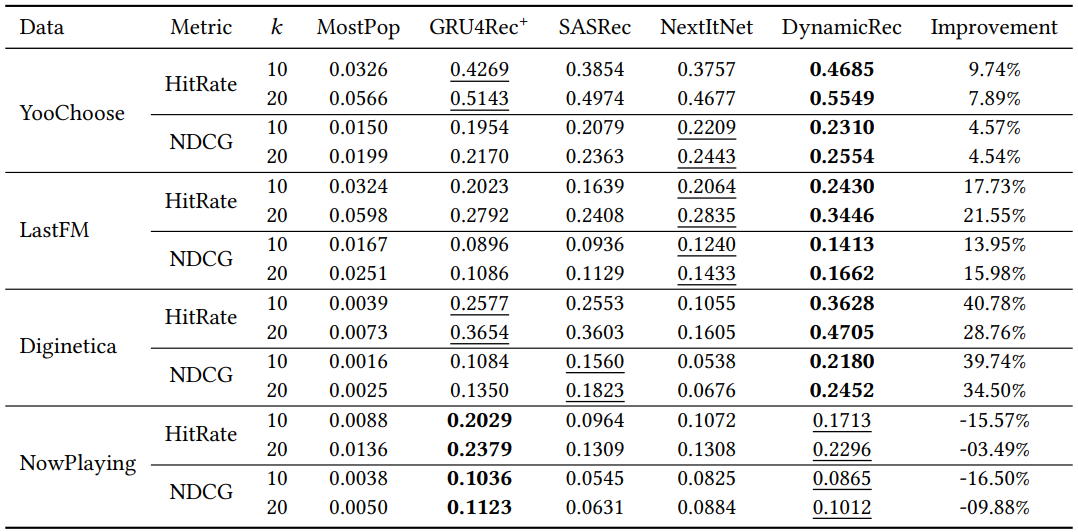

### References
1. https://github.com/Mehrab-Tanjim/DynamicRec
2. http://cseweb.ucsd.edu/~gary/pubs/mehrab-cikm-2020.pdf